## Kinematic Replay of Experimentally Recorded Behavior

**Authors:** Sibo Wang-Chen, Thomas Ka Chung Lam

### Overview

In this tutorial, we replay experimentally recorded leg kinematics of a walking *Drosophila* in the MuJoCo physics simulator. The experimental setup involved a tethered fly walking on an air-suspended spherical treadmill, filmed by seven cameras from different angles. Joint positions were estimated in 3D using [DeepFly3D](https://doi.org/10.7554/eLife.48571) (Günel et al., *eLife* 2019), and inverse kinematics was used to recover the angle at each degree of freedom (DoF).

Using a PD controller, we actuate the simulated fly's DoFs at these recorded angles to test whether the fly can walk untethered on flat terrain — as demonstrated in the original [NeuroMechFly](https://doi.org/10.1038/s41592-022-01466-7) paper (Lobato-Rios et al., *Nature Methods* 2022).

### Loading the recorded kinematics

In [1]:
from flygym import assets_dir
import numpy as np

data = np.load(assets_dir / "demo" / "210902_pr_fly1.npz")

dof_angles = data["dof_angles"]  # shape: (num_frames, num_dofs)
dof_names = [str(s) for s in data["dof_order"]]
recording_fps = data["fps"]

print(f"Shape (frames × DoFs): {dof_angles.shape}")
print(f"Recording FPS: {recording_fps}")
print(f"DoFs: {', '.join(dof_names[:3])}, …")

Shape (frames × DoFs): (2000, 42)
Recording FPS: 2000
DoFs: c_thorax-lf_coxa-yaw, c_thorax-lf_coxa-pitch, c_thorax-lf_coxa-roll, …


### Visualising DoF angle time series

Each leg has several actuated DoFs. Let's plot the recorded joint angles over time, grouped by leg:

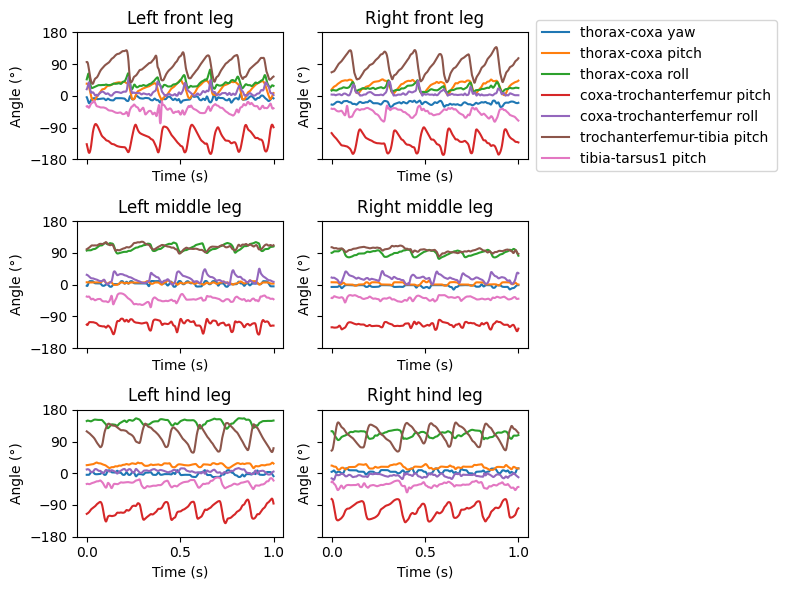

In [2]:
import re
import matplotlib.pyplot as plt

LEG_NAMES = ["lf", "lm", "lh", "rf", "rm", "rh"]
SIDE_LABELS = {"l": "Left", "r": "Right"}
POSITION_LABELS = {"f": "front", "m": "middle", "h": "hind"}

fig, axes = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)

# Plot each DoF on the corresponding leg's subplot
time_s = np.arange(dof_angles.shape[0]) / recording_fps
for dof_name, angles_deg in zip(dof_names, np.rad2deg(dof_angles).T):
    seg1, leg, seg2, angle_type = re.match(r".+_(.+)-(.+)_(.+)-(.+)", dof_name).groups()
    ax = axes.T.ravel()[LEG_NAMES.index(leg)]
    ax.plot(time_s, angles_deg, label=f"{seg1}-{seg2} {angle_type}")

# Label each subplot
for leg, ax in zip(LEG_NAMES, axes.T.ravel()):
    ax.set_title(f"{SIDE_LABELS[leg[0]]} {POSITION_LABELS[leg[1]]} leg")
    ax.set_ylim(-180, 180)
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (°)")

axes[0, 1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()

### Interpolating to the simulation time step

The recorded data is sampled at 2,000 Hz. We interpolate it to match the simulation time step $\Delta t = 10^{-4}\,\text{s}$ (i.e. 10,000 Hz):

In [3]:
from scipy.interpolate import interp1d

SIM_TIMESTEP = 1e-4  # seconds

original_time = np.arange(dof_angles.shape[0]) / recording_fps
target_time = np.arange(0, original_time[-1], SIM_TIMESTEP)

interpolator = interp1d(original_time, dof_angles, axis=0)
dof_angles_interp = interpolator(target_time)

print(f"Original frames: {len(dof_angles):,}")
print(f"Interpolated frames: {len(dof_angles_interp):,}")
print(f"Interpolated shape: {dof_angles_interp.shape}")

Original frames: 2,000
Interpolated frames: 9,995
Interpolated shape: (9995, 42)


### Setting up the simulation

We create a fly model with position-actuated leg joints and place it on flat terrain. A tracking camera is attached for rendering:

In [4]:
from flygym import assets_dir, Simulation
from flygym.compose import Fly, ActuatorType, FlatGroundWorld
from flygym.anatomy import Skeleton, JointPreset, ActuatedDOFPreset, AxisOrder
from flygym.compose.pose import KinematicPose
from flygym.utils.math import Rotation3D

# --- Fly configuration ---
axis_order = AxisOrder.YAW_PITCH_ROLL
joint_preset = JointPreset.LEGS_ONLY
dof_preset = ActuatedDOFPreset.LEGS_ACTIVE_ONLY
actuator_type = ActuatorType.POSITION
position_gain = 50.0
neutral_pose_path = assets_dir / "model/pose/neutral.yaml"

spawn_pos = (0, 0, 0.7)  # (x, y, z) in mm
spawn_rot = Rotation3D("quat", (1, 0, 0, 0))  # identity quaternion

# --- Build the fly ---
fly = Fly()

skeleton = Skeleton(axis_order=axis_order, joint_preset=joint_preset)
neutral_pose = KinematicPose(path=neutral_pose_path)
fly.add_joints(skeleton, neutral_pose=neutral_pose)

actuated_dofs = fly.skeleton.get_actuated_dofs_from_preset(dof_preset)
fly.add_actuators(
    actuated_dofs,
    actuator_type=actuator_type,
    kp=position_gain,
    neutral_input=neutral_pose,
)

fly.colorize()
tracking_cam = fly.add_tracking_camera()

# --- Build the world and simulation ---
world = FlatGroundWorld()
world.add_fly(fly, spawn_pos, spawn_rot)

sim = Simulation(world)

# --- Attach a renderer ---
PLAYBACK_SPEED = 0.2  # render at 20 % real-time
OUTPUT_FPS = 25  # video frame rate at that playback speed
# Internally this renders 25 / 0.2 = 125 frames per simulated second.

renderer = sim.set_renderer(
    camera=tracking_cam, playback_speed=PLAYBACK_SPEED, output_fps=OUTPUT_FPS
)

### Reordering DoFs to match the simulation

The DoF ordering in the recorded data may differ from the simulation's internal ordering. We reorder the columns accordingly:

In [5]:
sim_dof_order = [dof.name for dof in fly.get_actuated_jointdofs_order(actuator_type)]

if tuple(sim_dof_order) != tuple(dof_names):
    reorder_idx = [dof_names.index(name) for name in sim_dof_order]
    dof_angles_sorted = dof_angles_interp[:, reorder_idx]
    print("DoF columns reordered to match simulation.")
else:
    dof_angles_sorted = dof_angles_interp
    print("DoF ordering already matches — no reordering needed.")

DoF ordering already matches — no reordering needed.


## Running the kinematic replay

During the warmup period the fly holds its neutral pose and settles onto the ground. After that, we feed the recorded joint angles as control inputs at each time step:

In [6]:
from tqdm import trange

WARMUP_DURATION = 0.05  # seconds — let the fly settle before replaying
num_warmup_steps = int(WARMUP_DURATION / SIM_TIMESTEP)
num_sim_steps = dof_angles_sorted.shape[0]

for step in trange(num_warmup_steps + num_sim_steps, desc="Simulating"):
    if step >= num_warmup_steps:
        data_idx = step - num_warmup_steps
        sim.set_actuator_inputs(fly.name, actuator_type, dof_angles_sorted[data_idx, :])

    sim.step()
    sim.render_as_needed()

Simulating: 100%|██████████| 10495/10495 [00:37<00:00, 278.33it/s]


In [7]:
renderer.show_in_notebook()  # inline video preview

### Saving the video

In [8]:
from pathlib import Path

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

video_path = output_dir / "kinematic_replay.mp4"
renderer.save_video(video_path)
print(f"Video saved to {video_path}")

Video saved to outputs\kinematic_replay.mp4
